# Homework 3: Text mining

This assignment is about how to use text data to build predictive models. Before starting this assignment, make sure you read the Trans-American Airlines case study. The data for the case study is in the file "tweets.csv".

## Loading the data

Before you answer the questions below, let's first load the data that was labeled by your assistant.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("tweets.csv")
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,name,retweet_count,text,tweet_created,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,cairdin,0,@TAA What @dhepburn said.,2/24/2015 11:35,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,jnardino,0,@TAA plus you've added commercials to the expe...,2/24/2015 11:15,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,yvonnalynn,0,@TAA I didn't today... Must mean I need to tak...,2/24/2015 11:15,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,jnardino,0,@TAA it's really aggressive to blast obnoxious...,2/24/2015 11:15,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,jnardino,0,@TAA and it's a really big bad thing about it,2/24/2015 11:14,Pacific Time (US & Canada)


## Question 1: Target Variable

According to the case study, what should be the target variable that we should predict to address the problem discussed in the case study. Explain your choice of target variable, and set the target variable in the following code cell

In [ ]:
"""
As we would like to know if the tweets are related to customer service issue,
we create a customer_service_issue variable as the target variable, which we first check if the sentiment check if the airline_sentiment is
negative, then we check if negativereason is Customer Service Issue.
1 for CS related plus negative sentiment, 0 otherwise.
"""

df['customer_service_issue'] = np.where(((df["negativereason"]=="Customer Service Issue") & (df["airline_sentiment"]=="negative")), 1, 0)

## Question 2: Building Predictive Models

The following code splits the data into a training set (13,640 tweets) and a holdout set (1,000 tweets). It then transforms the text of each tweet using the bag-of-words technique. Each possible word that could appear in a tweet is represented as a binary feature that takes a value of 1 if the word is present in the tweet and a value of 0 otherwise.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

text_data = df['text']
y=df["customer_service_issue"]
text_train, text_holdout, y_train, y_holdout = train_test_split(text_data, y, test_size=1000, random_state=0)
binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(text_train)
X_binary_train = binary_vectorizer.transform(text_train)
X_binary_holdout = binary_vectorizer.transform(text_holdout)
# X_binary_train

As you can see, the matrix that results from transforming the text in the training data consists of 13,640 rows (tweets) and 14,436 features (words)! The output above also shows that the data is being stored in a sparse matrix (as opposed to the typical dense matrix). Given the shape of the matrix, this means there are \~197 million cells that should have values. However, from the above, we can see that only \~218k cells (\~0.1% of the cells) have values! Why is this?

To save space, sklearn uses a sparse matrix. This means that only values that are not zero are stored, which saves a ton of memory and makes the computation of models much more efficient!

## Build a Multinomial Naive Bayes model use training data
You can use GridSearchCV with 10 folds to try different alpha (Additive (Laplace/Lidstone) smoothing parameter) to find out the best alpha, use AUC as score method. Report the test Accuracy, classification report and AUC for this Multinomial Naive Byes.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, confusion_matrix


In [ ]:
# Create the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Define the parameter grid for alpha values
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}

# Apply GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, scoring='roc_auc', cv=10)
grid_search.fit(X_binary_train, y_train)

# Retrieve the best alpha value and corresponding AUC score
best_alpha = grid_search.best_params_['alpha']
best_auc = grid_search.best_score_

# Train the Multinomial Naive Bayes classifier using the best alpha
best_classifier = MultinomialNB(alpha=best_alpha)
best_classifier.fit(X_binary_train, y_train)

# Evaluate the classifier on the holdout set
predicted_y = best_classifier.predict(X_binary_holdout)
accuracy = accuracy_score(y_holdout, predicted_y)
classification_report = classification_report(y_holdout, predicted_y)
auc = roc_auc_score(y_holdout, predicted_y)

print("Best Alpha: ", best_alpha)
print("Test Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)
print("AUC Score:", auc)

Best Alpha:  0.5
Test Accuracy: 0.854
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       801
           1       0.65      0.57      0.61       199

    accuracy                           0.85      1000
   macro avg       0.77      0.75      0.76      1000
weighted avg       0.85      0.85      0.85      1000

AUC Score: 0.7464664144693506


### Test the Multinomial Naive Bayes model on the hold out testing set
Report the performance result, including accuracy, precision, recall, confusion matrix and AUC
How do you evaluate the testing result?

In [ ]:
# Test the Multinomial Naive Bayes model on the holdout testing set
predicted_y = best_classifier.predict(X_binary_holdout)

# Calculate accuracy
accuracy = accuracy_score(y_holdout, predicted_y)

# Calculate precision
precision = precision_score(y_holdout, predicted_y)

# Calculate recall
recall = recall_score(y_holdout, predicted_y)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_holdout, predicted_y)

# Calculate AUC
auc = roc_auc_score(y_holdout, predicted_y)

# Print the performance results
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:")
print(confusion_mat)
print("AUC Score:", auc)

Test Accuracy: 0.854
Precision: 0.653179190751445
Recall: 0.5678391959798995
Confusion Matrix:
[[741  60]
 [ 86 113]]
AUC Score: 0.7464664144693506


## Build a Logistic Regression model use training data
You can use GridSearchCV with 10-fold to try different C (L1 regularization strangth parameter) to find out the best C. Use the parameters solver="liblinear" and set AUC as score method. Report the test Accuracy, classification report and AUC for this Logistic Regression Model.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Write the code to find the best C (L1) for Logistic Regression model, using GridSearchCV
# Logis = LogisticRegression(penalty ='l1', C = 1, solver="liblinear")

# score = cross_val_score(Logis,X_binary_train,y_train,cv=10).mean()
# score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Create the Logistic Regression classifier
logreg_classifier = LogisticRegression(solver='liblinear')

# Define the parameter grid for C values
param_grid = {'C': [0.1, 0.5, 1.0, 1.5, 2.0]}

# Apply GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=logreg_classifier, param_grid=param_grid, scoring='roc_auc', cv=10)
grid_search.fit(X_binary_train, y_train)

# Retrieve the best C value and corresponding AUC score
best_C = grid_search.best_params_['C']
best_auc = grid_search.best_score_

# Train the Logistic Regression classifier using the best C
best_classifier_log = LogisticRegression(C=best_C, solver='liblinear')
best_classifier_log.fit(X_binary_train, y_train)

# Evaluate the classifier on the holdout set
predicted_y = best_classifier_log.predict(X_binary_holdout)
accuracy = accuracy_score(y_holdout, predicted_y)
classification_report = classification_report(y_holdout, predicted_y)
auc = roc_auc_score(y_holdout, predicted_y)

print("Best C: ", best_C)
print("Test Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)
print("AUC Score:", auc)

Best C:  0.1
Test Accuracy: 0.853
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       801
           1       0.71      0.45      0.55       199

    accuracy                           0.85      1000
   macro avg       0.79      0.70      0.73      1000
weighted avg       0.84      0.85      0.84      1000

AUC Score: 0.7005219606145585


### Test the Logistic Regression model on the hold out testing set
Report the performance result, including accuracy, precision, recall, confusion matrix and AUC
How do you evaluate the testing result? and how do you compare the performance of logistic regression model with the previous Naive Bayes Model?

In [ ]:
# Test the Logistic Regression model on the holdout testing set
predicted_y = best_classifier_log.predict(X_binary_holdout)

# Calculate accuracy
accuracy = accuracy_score(y_holdout, predicted_y)

# Calculate precision
precision = precision_score(y_holdout, predicted_y)
precision_of_log_test_data = precision

# Calculate recall
recall = recall_score(y_holdout, predicted_y)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_holdout, predicted_y)

# Calculate AUC
auc = roc_auc_score(y_holdout, predicted_y)

# Print the performance results
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:")
print(confusion_mat)
print("AUC Score:", auc)

Test Accuracy: 0.853
Precision: 0.7063492063492064
Recall: 0.4472361809045226
Confusion Matrix:
[[764  37]
 [110  89]]
AUC Score: 0.7005219606145585


Comparsion

Accuracy:
Logistic Regression: 0.853
Multinomial Naive Bayes: 0.854

Accuracy: Both models have similar accuracy

Precision:
Logistic Regression: 0.706
Multinomial Naive Bayes: 0.653

Precision: The Logistic Regression model has higher precision compared to the Multinomial Naive Bayes model, indicating a better ability to correctly identify positive instances.

Recall:
Logistic Regression: 0.447
Multinomial Naive Bayes: 0.568

Recall: The Multinomial Naive Bayes model has higher recall compared to the Logistic Regression model, indicating a better ability to identify true positive instances.

AUC Score:
Logistic Regression: 0.701
Multinomial Naive Bayes: 0.746

AUC Score: The Multinomial Naive Bayes model has a higher AUC score compared to the Logistic Regression model, suggesting better discrimination capability in distinguishing between positive and negative instances.

Overall, the Multinomial Naive Bayes model shows a slightly better performance in terms of recall and AUC, while the Logistic Regression model exhibits higher precision.

## Question 3: Most Predictive Words

The code below shows the features with the largest coefficients in your logistic regression model. Use it to show the most predictive words. Pick a few words that catch your attention (at least 2 or 3). Why do you think these words are predictive?

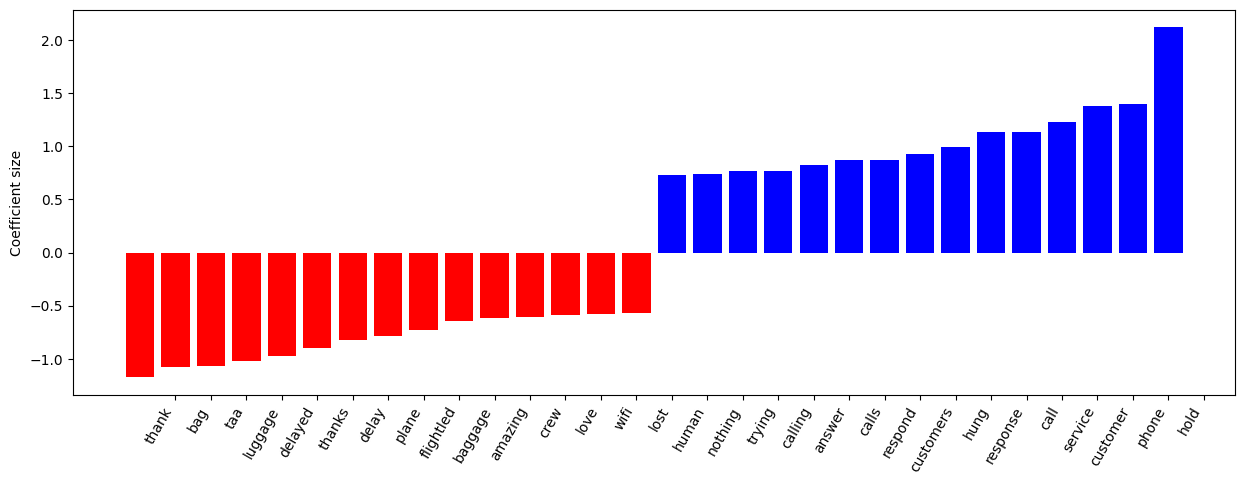

In [ ]:
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=15):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.ylabel("Coefficient size")
    plt.show()

feature_names = binary_vectorizer.get_feature_names_out()
plot_coefficients(best_classifier_log, feature_names) #<--remember to change "my_model" to the model name your logistic regression


"hold" with a coefficient size of 2:
   - The positive coefficient for this word might suggest that customers who do not mention being put on hold or have shorter hold times tend to have a positive outcome. A positive outcome could mean a quicker resolution or a better overall experience.

"phone" with a coefficient size of 1.5:
   - The positive coefficient for this word could indicate that customers who do not mention negative experiences or issues related to phone interactions tend to have a positive outcome. This might imply that positive phone interactions contribute to customer satisfaction.

"thanks" with a coefficient size of -1:
   - The negative coefficient for this word might indicate that customers who express gratitude or thanks in their reviews tend to have a positive outcome. This could imply that customers who express appreciation are more likely to have a positive overall experience.

"luggage" with a coefficient size of -0.8:
   - Similar to "bag," the negative coefficient for this word might indicate that customers who do not mention negative experiences or issues related to luggage tend to have a positive outcome.

My guess is that mostly poor customer service is related to phone call, probably customer are dissatisfied with being put on hold or the duration is too long. It means the company is doing badly in phone call, and whenever the word "phone" is shown on the text, it probably means ppl are complaining on the phone call experience again.

Meanwhile, for those tweets with words like Thanks, bag, baggage luggage. Probably the company is doing good in luggage management. Thats why ppl are praise them in the related area all the time. Thats why whenever the comment is related to Luggage, customer are complimenting the luggage service.


## Question 4: Text Mining Limitations

For the purposes of this question, suppose we use a threshold of 0.5 to predict the target variable. The following code prints the text of five false positives and five false negatives in the test set. Why do you think the model made these mistakes? Please use logsitc regression model you build before for this question

In [ ]:
predictions = best_classifier_log.predict(X_binary_holdout) #<--remember to change "my_model" to the model name your logistic regression
false_positives = text_holdout[(predictions == 1) & (y_holdout == 0)]
false_negatives = text_holdout[(predictions == 0) & (y_holdout == 1)]
print("===== FALSE POSITIVES") #predict negative sentiment but actually positive/neutral
print(false_positives.head(5).values)
print("===== FALSE NEGATIVES")
print(false_negatives.head(5).values)

===== FALSE POSITIVES
["@TAA In car gng to DFW. Pulled over 1hr ago - very icy roads. On-hold with AA since 1hr. Can't reach arpt for AA2450. Wat 2 do?"
 '@TAA Can you find us a flt out of LAX that is sooner than midnight on Monday? That would be great customer service 😃'
 '@TAA customer service at its finest'
 '@TAA you should be contacting her for a refund - dm me and I will provide phone number'
 '@TAA VERY upset that I cannot select seats for Tuesday flight online or over the phone. Terrible customer service :( Please help!']
===== FALSE NEGATIVES
['@TAA still no response from AA. great job guys!'
 '@TAA hello??? Anyone there?'
 "@TAA Didn't see travel had to be compete for unused funds by expiration date hidden in the fine print. Never saw that before."
 '@TAA awesome... Doors close in 2 minutes, flight leaves in 17 minutes... And the plane just got here. WTH?'
 '@TAA nothing to do with Mother Nature, more like poor commutation.']


People can be ironic/ ambiguity sometimes, like they are saying "great job guys", but actually they are unhappy with the ignorance of the company.or there would be case which the algorithms struggle to interpret the intended meaning, which can lead to misclassification. also the model might fail to understand the context of a text.

another potential issue would be the quality of the data. Like for the tweet with text "VERY upset that I cannot select seats for Tuesday flight online or over the phone. Terrible customer service." Its actually related to customer service as its clearly stated in the text but the category/negativereason is labelled to be related to Flight Booking Problems.



## Question 5: Using the model

Print the top 20 tweets in the holdout set with the highest probability of having a positive value for the target variable. How do you evaluate the result? how do you compare this with majoirty classifier?

In [ ]:
y_

In [ ]:
probabilities = best_classifier_log.predict_proba(X_binary_holdout)[:, 1] #<--remember to change "my_model" to the model name your logistic regression
TestResult = y_holdout.to_frame()
TestResult['ProbabilityOfCSI'] = probabilities

# This code shows the predictions for the top 20 tweets most likely to be Customer Service Issue related
# (according to the model) and whether they actually Customer Service Issue.
Top20 = TestResult.sort_values('ProbabilityOfCSI', ascending=False)[:20]
Top20

,customer_service_issue,ProbabilityOfCSI
11932,1,0.998387
6168,1,0.996883
10109,1,0.995490
1523,1,0.993589
8848,1,0.993043
4386,0,0.980295
13150,1,0.978440
5569,1,0.966878
13687,1,0.961848
10133,1,0.954308


In [ ]:
print("Number of NegativeReason that is related to CSI:")
Top20['customer_service_issue'].value_counts()

Number of NegativeReason that is related to CSI:


1    18
0     2
Name: customer_service_issue, dtype: int64

In [ ]:
true_positive = 18
false_positive = 2
precision_of_top_20 = true_positive/(false_positive+true_positive)
print("precision_of_log_test_data: ", precision_of_log_test_data)
print("precision_of_top_20", precision_of_top_20)
print("We can tell the precision (ability of identifying true positive) is better for the top_20 tweets, which is a good thing, as we want to see the most relevant result")

precision_of_log_test_data:  0.7063492063492064
precision_of_top_20 0.9


## Question 6: How many tweets to review each day?
Let us assume that one false positive (models says it is customer service issue but it is actually not) costs 10 dollars and one true positive earns 10 dollars. Given your model output, how would you suggest your boss to make changes about how many tweets to review each day?

In [ ]:
TestResult

,customer_service_issue,ProbabilityOfCSI
13983,0,0.594753
14484,0,0.039998
6403,0,0.281514
9653,0,0.137394
13268,1,0.296493
...,...,...
1818,0,0.356734
5747,0,0.082822
146,0,0.084756
230,0,0.020661


In [ ]:
# TestResult.to_csv("TestResult.csv")

13983    0
14484    0
6403     0
Name: customer_service_issue, dtype: int64


In [ ]:
false_positive_cost = 10
true_positive_earnings = 10

# Calculate net earnings for different numbers of tweets reviewed each day
max_net_earnings = 0
optimal_num_tweets = 0

for num_tweets_reviewed in range(1, len(TestResult) + 1):
    # Get the predictions for the first num_tweets_reviewed rows
    # predictions = TestResult['customer_service_issue'].head(num_tweets_reviewed)
    data = TestResult[0:num_tweets_reviewed]

    net_earnings = 0

    for index,row in data.iterrows():
      if row["customer_service_issue"] == 1 and row["ProbabilityOfCSI"] > 0.5:
        net_earnings += 10
      elif row["customer_service_issue"] == 0 and row["ProbabilityOfCSI"] > 0.5:
        net_earnings -= 10

    # Update the optimal number of tweets and net earnings if necessary
    if net_earnings > max_net_earnings:
        max_net_earnings = net_earnings
        optimal_num_tweets = num_tweets_reviewed

# Print the optimal number of tweets to review each day
print("Optimal number of tweets to review each day:", optimal_num_tweets)

Optimal number of tweets to review each day: 981


<font color='red'>YOUR WRITTEN ANSWER GOES HERE</font>

## Question 7: Take a look at the top 20 tweets, what seems to be the main problem that Trans-American Airlines is facing?

In [ ]:
print(text_holdout.iloc[(-probabilities).argsort()][:20].values)

['@TAA I have been on hold w/customer service line for 68 minutes.  This after I was on phone with an agent for 35 min b/f call droped'
 '@TAA was wondering is there a reason why customer service is so busy? Been on hold past few days for many hours No answer Help plz'
 '@TAA I waited customer service 32 minutes on the phone w/o response. Had to hung up in the end since my battery died due to waiting!'
 "@TAA I'm really glad I just waited on the phone for over an hour to be sent to a voicemail. Your customer service sucks. Nothing has been"
 '@TAA Hold for 15 min, a couple of rings, then "mailbox has not been set up yet." Customer service forwarding to their cell phones? C\'mon'
 "@TAA trying to change my reservation, been on hold for 45 minutes, and can't do it online-was directed to call. Help?"
 "@TAA @EdPlotts don't bother trying to get anywhere with their customer service team either as take 2+ months and counting to reply"
 "@TAA  after 38 minutes on the phone I'm given another n

<font color='red'>



*   Long wait times on hold: 8 tweets
*   Lack of response from customer service: 4 tweets
*   Dropped calls: 2 tweets
*   Inability to change reservations online: 1 tweet
*   Unhelpful automated messages: 1 tweet
*   Difficulties in reaching a live agent: 1 tweet
*   Unacceptable treatment by customer service agents: 1 tweet
*   Lack of option to hold: 1 tweet
*   Other miscellaneous complaints: 1 tweet
</font>

<font color='red'>

Based on the top 20 tweets provided, the main problem that Trans-American Airlines (TAA) seems to be facing is poor customer service. The tweets highlight issues such as excessively long wait times on hold, dropped calls, lack of response from customer service representatives, inability to change reservations online, unhelpful automated messages, and difficulties in reaching a live agent. Customers express frustration, dissatisfaction, and disappointment with the customer service provided by TAA. These complaints suggest that TAA needs to address its customer service operations to improve responsiveness, reduce wait times, and enhance overall customer satisfaction.</font>